In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 30:12 - loss: 2.3981

  9/146 [>.............................] - ETA: 0s - loss: 2.3975   

 17/146 [==>...........................] - ETA: 0s - loss: 2.3962

 25/146 [====>.........................] - ETA: 0s - loss: 2.3935

 33/146 [=====>........................] - ETA: 0s - loss: 2.3886

 42/146 [=======>......................] - ETA: 0s - loss: 2.3807

 51/146 [=========>....................] - ETA: 0s - loss: 2.3719

 60/146 [===========>..................] - ETA: 0s - loss: 2.3634

 68/146 [============>.................] - ETA: 0s - loss: 2.3563

 77/146 [==============>...............] - ETA: 0s - loss: 2.3488

 86/146 [================>.............] - ETA: 0s - loss: 2.3419

 95/146 [==================>...........] - ETA: 0s - loss: 2.3355

104/146 [====================>.........] - ETA: 0s - loss: 2.3297

113/146 [======================>.......] - ETA: 0s - loss: 2.3242

121/146 [=======================>......] - ETA: 0s - loss: 2.3194

130/146 [=========================>....] - ETA: 0s - loss: 2.3143

139/146 [===========================>..] - ETA: 0s - loss: 2.3093

146/146 [==============================] - ETA: 0s - loss: 2.3055

146/146 [==============================] - 14s 10ms/step - loss: 2.3050 - val_loss: 2.0299


Epoch 2/100
  1/146 [..............................] - ETA: 1s - loss: 2.0810

 10/146 [=>............................] - ETA: 0s - loss: 2.0728

 18/146 [==>...........................] - ETA: 0s - loss: 2.0727

 27/146 [====>.........................] - ETA: 0s - loss: 2.0714

 36/146 [======>.......................] - ETA: 0s - loss: 2.0695

 45/146 [========>.....................] - ETA: 0s - loss: 2.0675

 54/146 [==========>...................] - ETA: 0s - loss: 2.0653

 63/146 [===========>..................] - ETA: 0s - loss: 2.0632

 72/146 [=============>................] - ETA: 0s - loss: 2.0612

 81/146 [===============>..............] - ETA: 0s - loss: 2.0592

 90/146 [=================>............] - ETA: 0s - loss: 2.0572

 99/146 [===================>..........] - ETA: 0s - loss: 2.0553

108/146 [=====================>........] - ETA: 0s - loss: 2.0535

117/146 [=======================>......] - ETA: 0s - loss: 2.0518

126/146 [========================>.....] - ETA: 0s - loss: 2.0500

135/146 [==========================>...] - ETA: 0s - loss: 2.0483

144/146 [============================>.] - ETA: 0s - loss: 2.0466

146/146 [==============================] - 1s 6ms/step - loss: 2.0461 - val_loss: 1.9142


Epoch 3/100
  1/146 [..............................] - ETA: 1s - loss: 1.9562

 10/146 [=>............................] - ETA: 0s - loss: 1.9691

 18/146 [==>...........................] - ETA: 0s - loss: 1.9699

 27/146 [====>.........................] - ETA: 0s - loss: 1.9684

 36/146 [======>.......................] - ETA: 0s - loss: 1.9671

 45/146 [========>.....................] - ETA: 0s - loss: 1.9658

 54/146 [==========>...................] - ETA: 0s - loss: 1.9646

 62/146 [===========>..................] - ETA: 0s - loss: 1.9634

 71/146 [=============>................] - ETA: 0s - loss: 1.9621

 80/146 [===============>..............] - ETA: 0s - loss: 1.9608

 89/146 [=================>............] - ETA: 0s - loss: 1.9595

 98/146 [===================>..........] - ETA: 0s - loss: 1.9582

107/146 [====================>.........] - ETA: 0s - loss: 1.9570

115/146 [======================>.......] - ETA: 0s - loss: 1.9560

124/146 [========================>.....] - ETA: 0s - loss: 1.9549

133/146 [==========================>...] - ETA: 0s - loss: 1.9538

142/146 [============================>.] - ETA: 0s - loss: 1.9528

146/146 [==============================] - 1s 6ms/step - loss: 1.9522 - val_loss: 1.8500


Epoch 4/100


  1/146 [..............................] - ETA: 1s - loss: 1.8829

 10/146 [=>............................] - ETA: 0s - loss: 1.8902

 19/146 [==>...........................] - ETA: 0s - loss: 1.8929

 28/146 [====>.........................] - ETA: 0s - loss: 1.8947

 37/146 [======>.......................] - ETA: 0s - loss: 1.8956

 46/146 [========>.....................] - ETA: 0s - loss: 1.8960

 55/146 [==========>...................] - ETA: 0s - loss: 1.8963

 64/146 [============>.................] - ETA: 0s - loss: 1.8963

 73/146 [==============>...............] - ETA: 0s - loss: 1.8962

 82/146 [===============>..............] - ETA: 0s - loss: 1.8960

 91/146 [=================>............] - ETA: 0s - loss: 1.8958

100/146 [===================>..........] - ETA: 0s - loss: 1.8956

109/146 [=====================>........] - ETA: 0s - loss: 1.8955

118/146 [=======================>......] - ETA: 0s - loss: 1.8954

127/146 [=========================>....] - ETA: 0s - loss: 1.8951

136/146 [==========================>...] - ETA: 0s - loss: 1.8949

145/146 [============================>.] - ETA: 0s - loss: 1.8947

146/146 [==============================] - 1s 6ms/step - loss: 1.8946 - val_loss: 1.8272


Epoch 5/100
  1/146 [..............................] - ETA: 1s - loss: 1.8492

 10/146 [=>............................] - ETA: 0s - loss: 1.8733

 18/146 [==>...........................] - ETA: 0s - loss: 1.8749

 27/146 [====>.........................] - ETA: 0s - loss: 1.8755

 36/146 [======>.......................] - ETA: 0s - loss: 1.8759

 45/146 [========>.....................] - ETA: 0s - loss: 1.8757

 53/146 [=========>....................] - ETA: 0s - loss: 1.8750

 62/146 [===========>..................] - ETA: 0s - loss: 1.8746

 71/146 [=============>................] - ETA: 0s - loss: 1.8742

 80/146 [===============>..............] - ETA: 0s - loss: 1.8739

 89/146 [=================>............] - ETA: 0s - loss: 1.8737

 98/146 [===================>..........] - ETA: 0s - loss: 1.8735

107/146 [====================>.........] - ETA: 0s - loss: 1.8734

116/146 [======================>.......] - ETA: 0s - loss: 1.8733

125/146 [========================>.....] - ETA: 0s - loss: 1.8733

134/146 [==========================>...] - ETA: 0s - loss: 1.8732

143/146 [============================>.] - ETA: 0s - loss: 1.8730

146/146 [==============================] - 1s 6ms/step - loss: 1.8730 - val_loss: 1.8107


Epoch 6/100
  1/146 [..............................] - ETA: 1s - loss: 1.8427

 10/146 [=>............................] - ETA: 0s - loss: 1.8582

 19/146 [==>...........................] - ETA: 0s - loss: 1.8616

 28/146 [====>.........................] - ETA: 0s - loss: 1.8606

 37/146 [======>.......................] - ETA: 0s - loss: 1.8600

 46/146 [========>.....................] - ETA: 0s - loss: 1.8595

 55/146 [==========>...................] - ETA: 0s - loss: 1.8590

 64/146 [============>.................] - ETA: 0s - loss: 1.8587

 73/146 [==============>...............] - ETA: 0s - loss: 1.8586

 81/146 [===============>..............] - ETA: 0s - loss: 1.8586

 90/146 [=================>............] - ETA: 0s - loss: 1.8584

 99/146 [===================>..........] - ETA: 0s - loss: 1.8582

108/146 [=====================>........] - ETA: 0s - loss: 1.8581

117/146 [=======================>......] - ETA: 0s - loss: 1.8579



125/146 [========================>.....] - ETA: 0s - loss: 1.8578

133/146 [==========================>...] - ETA: 0s - loss: 1.8577

142/146 [============================>.] - ETA: 0s - loss: 1.8575

146/146 [==============================] - 1s 6ms/step - loss: 1.8574 - val_loss: 1.8029


Epoch 7/100
  1/146 [..............................] - ETA: 0s - loss: 1.7945

 10/146 [=>............................] - ETA: 0s - loss: 1.8235

 19/146 [==>...........................] - ETA: 0s - loss: 1.8337

 27/146 [====>.........................] - ETA: 0s - loss: 1.8380

 36/146 [======>.......................] - ETA: 0s - loss: 1.8403

 45/146 [========>.....................] - ETA: 0s - loss: 1.8415

 54/146 [==========>...................] - ETA: 0s - loss: 1.8421

 63/146 [===========>..................] - ETA: 0s - loss: 1.8421

 72/146 [=============>................] - ETA: 0s - loss: 1.8421

 81/146 [===============>..............] - ETA: 0s - loss: 1.8422

 90/146 [=================>............] - ETA: 0s - loss: 1.8422

 99/146 [===================>..........] - ETA: 0s - loss: 1.8421

108/146 [=====================>........] - ETA: 0s - loss: 1.8420

116/146 [======================>.......] - ETA: 0s - loss: 1.8419

125/146 [========================>.....] - ETA: 0s - loss: 1.8418

134/146 [==========================>...] - ETA: 0s - loss: 1.8418

143/146 [============================>.] - ETA: 0s - loss: 1.8417

146/146 [==============================] - 1s 6ms/step - loss: 1.8416 - val_loss: 1.7812


Epoch 8/100
  1/146 [..............................] - ETA: 1s - loss: 1.8397

 10/146 [=>............................] - ETA: 0s - loss: 1.8372

 19/146 [==>...........................] - ETA: 0s - loss: 1.8369

 28/146 [====>.........................] - ETA: 0s - loss: 1.8354

 37/146 [======>.......................] - ETA: 0s - loss: 1.8344

 46/146 [========>.....................] - ETA: 0s - loss: 1.8338

 55/146 [==========>...................] - ETA: 0s - loss: 1.8333

 64/146 [============>.................] - ETA: 0s - loss: 1.8329

 73/146 [==============>...............] - ETA: 0s - loss: 1.8325

 82/146 [===============>..............] - ETA: 0s - loss: 1.8321

 91/146 [=================>............] - ETA: 0s - loss: 1.8317

100/146 [===================>..........] - ETA: 0s - loss: 1.8313

109/146 [=====================>........] - ETA: 0s - loss: 1.8310

118/146 [=======================>......] - ETA: 0s - loss: 1.8306

127/146 [=========================>....] - ETA: 0s - loss: 1.8304

136/146 [==========================>...] - ETA: 0s - loss: 1.8302

145/146 [============================>.] - ETA: 0s - loss: 1.8300

146/146 [==============================] - 1s 6ms/step - loss: 1.8299 - val_loss: 1.7663


Epoch 9/100


  1/146 [..............................] - ETA: 1s - loss: 1.8057

 10/146 [=>............................] - ETA: 0s - loss: 1.8176

 18/146 [==>...........................] - ETA: 0s - loss: 1.8201

 27/146 [====>.........................] - ETA: 0s - loss: 1.8193

 36/146 [======>.......................] - ETA: 0s - loss: 1.8190

 45/146 [========>.....................] - ETA: 0s - loss: 1.8189

 54/146 [==========>...................] - ETA: 0s - loss: 1.8188

 63/146 [===========>..................] - ETA: 0s - loss: 1.8188

 72/146 [=============>................] - ETA: 0s - loss: 1.8185

 81/146 [===============>..............] - ETA: 0s - loss: 1.8181

 90/146 [=================>............] - ETA: 0s - loss: 1.8177

 99/146 [===================>..........] - ETA: 0s - loss: 1.8174

108/146 [=====================>........] - ETA: 0s - loss: 1.8171

117/146 [=======================>......] - ETA: 0s - loss: 1.8168

126/146 [========================>.....] - ETA: 0s - loss: 1.8165

134/146 [==========================>...] - ETA: 0s - loss: 1.8163

142/146 [============================>.] - ETA: 0s - loss: 1.8160

146/146 [==============================] - 1s 7ms/step - loss: 1.8158 - val_loss: 1.7490


Epoch 10/100
  1/146 [..............................] - ETA: 1s - loss: 1.7737

 10/146 [=>............................] - ETA: 0s - loss: 1.7962

 19/146 [==>...........................] - ETA: 0s - loss: 1.7963

 28/146 [====>.........................] - ETA: 0s - loss: 1.7970

 37/146 [======>.......................] - ETA: 0s - loss: 1.7976

 46/146 [========>.....................] - ETA: 0s - loss: 1.7982

 54/146 [==========>...................] - ETA: 0s - loss: 1.7983

 63/146 [===========>..................] - ETA: 0s - loss: 1.7983

 71/146 [=============>................] - ETA: 0s - loss: 1.7983

 80/146 [===============>..............] - ETA: 0s - loss: 1.7983

 89/146 [=================>............] - ETA: 0s - loss: 1.7984

 98/146 [===================>..........] - ETA: 0s - loss: 1.7986

107/146 [====================>.........] - ETA: 0s - loss: 1.7986

116/146 [======================>.......] - ETA: 0s - loss: 1.7986

125/146 [========================>.....] - ETA: 0s - loss: 1.7985

134/146 [==========================>...] - ETA: 0s - loss: 1.7983

143/146 [============================>.] - ETA: 0s - loss: 1.7982

146/146 [==============================] - 1s 6ms/step - loss: 1.7982 - val_loss: 1.7388


Epoch 11/100
  1/146 [..............................] - ETA: 1s - loss: 1.7917

 10/146 [=>............................] - ETA: 0s - loss: 1.7882

 18/146 [==>...........................] - ETA: 0s - loss: 1.7851

 27/146 [====>.........................] - ETA: 0s - loss: 1.7853

 36/146 [======>.......................] - ETA: 0s - loss: 1.7863

 45/146 [========>.....................] - ETA: 0s - loss: 1.7868

 54/146 [==========>...................] - ETA: 0s - loss: 1.7872

 62/146 [===========>..................] - ETA: 0s - loss: 1.7875

 71/146 [=============>................] - ETA: 0s - loss: 1.7876

 80/146 [===============>..............] - ETA: 0s - loss: 1.7876

 88/146 [=================>............] - ETA: 0s - loss: 1.7876

 97/146 [==================>...........] - ETA: 0s - loss: 1.7875

106/146 [====================>.........] - ETA: 0s - loss: 1.7873

115/146 [======================>.......] - ETA: 0s - loss: 1.7873

124/146 [========================>.....] - ETA: 0s - loss: 1.7872

133/146 [==========================>...] - ETA: 0s - loss: 1.7872

142/146 [============================>.] - ETA: 0s - loss: 1.7872



146/146 [==============================] - 1s 6ms/step - loss: 1.7872 - val_loss: 1.7307


Epoch 12/100
  1/146 [..............................] - ETA: 1s - loss: 1.8030

  9/146 [>.............................] - ETA: 0s - loss: 1.7961

 18/146 [==>...........................] - ETA: 0s - loss: 1.7926

 26/146 [====>.........................] - ETA: 0s - loss: 1.7899

 35/146 [======>.......................] - ETA: 0s - loss: 1.7874

 43/146 [=======>......................] - ETA: 0s - loss: 1.7859

 52/146 [=========>....................] - ETA: 0s - loss: 1.7849

 61/146 [===========>..................] - ETA: 0s - loss: 1.7845

 70/146 [=============>................] - ETA: 0s - loss: 1.7844

 79/146 [===============>..............] - ETA: 0s - loss: 1.7842

 88/146 [=================>............] - ETA: 0s - loss: 1.7840

 97/146 [==================>...........] - ETA: 0s - loss: 1.7837

106/146 [====================>.........] - ETA: 0s - loss: 1.7835

115/146 [======================>.......] - ETA: 0s - loss: 1.7832

123/146 [========================>.....] - ETA: 0s - loss: 1.7830

132/146 [==========================>...] - ETA: 0s - loss: 1.7828

141/146 [===========================>..] - ETA: 0s - loss: 1.7825

146/146 [==============================] - 1s 6ms/step - loss: 1.7824 - val_loss: 1.7252


Epoch 13/100
  1/146 [..............................] - ETA: 1s - loss: 1.7905

 10/146 [=>............................] - ETA: 0s - loss: 1.7822

 19/146 [==>...........................] - ETA: 0s - loss: 1.7813

 28/146 [====>.........................] - ETA: 0s - loss: 1.7791

 36/146 [======>.......................] - ETA: 0s - loss: 1.7779

 44/146 [========>.....................] - ETA: 0s - loss: 1.7775

 53/146 [=========>....................] - ETA: 0s - loss: 1.7771

 62/146 [===========>..................] - ETA: 0s - loss: 1.7768

 71/146 [=============>................] - ETA: 0s - loss: 1.7765

 79/146 [===============>..............] - ETA: 0s - loss: 1.7763

 88/146 [=================>............] - ETA: 0s - loss: 1.7760

 97/146 [==================>...........] - ETA: 0s - loss: 1.7759

106/146 [====================>.........] - ETA: 0s - loss: 1.7757

115/146 [======================>.......] - ETA: 0s - loss: 1.7755

124/146 [========================>.....] - ETA: 0s - loss: 1.7752

133/146 [==========================>...] - ETA: 0s - loss: 1.7750

142/146 [============================>.] - ETA: 0s - loss: 1.7747

146/146 [==============================] - 1s 6ms/step - loss: 1.7746 - val_loss: 1.7189


Epoch 14/100
  1/146 [..............................]

 - ETA: 0s - loss: 1.7546

  9/146 [>.............................] - ETA: 0s - loss: 1.7796

 18/146 [==>...........................] - ETA: 0s - loss: 1.7760

 27/146 [====>.........................] - ETA: 0s - loss: 1.7739

 36/146 [======>.......................] - ETA: 0s - loss: 1.7725

 44/146 [========>.....................] - ETA: 0s - loss: 1.7718

 53/146 [=========>....................] - ETA: 0s - loss: 1.7714

 62/146 [===========>..................] - ETA: 0s - loss: 1.7710

 71/146 [=============>................] - ETA: 0s - loss: 1.7706

 80/146 [===============>..............] - ETA: 0s - loss: 1.7703

 89/146 [=================>............] - ETA: 0s - loss: 1.7701

 98/146 [===================>..........] - ETA: 0s - loss: 1.7699

107/146 [====================>.........] - ETA: 0s - loss: 1.7697

115/146 [======================>.......] - ETA: 0s - loss: 1.7695

124/146 [========================>.....] - ETA: 0s - loss: 1.7693

133/146 [==========================>...] - ETA: 0s - loss: 1.7692

142/146 [============================>.] - ETA: 0s - loss: 1.7691

146/146 [==============================] - 1s 6ms/step - loss: 1.7690 - val_loss: 1.7156


Epoch 15/100


  1/146 [..............................] - ETA: 1s - loss: 1.7203

 10/146 [=>............................] - ETA: 0s - loss: 1.7479

 18/146 [==>...........................] - ETA: 0s - loss: 1.7556

 26/146 [====>.........................] - ETA: 0s - loss: 1.7586

 34/146 [=====>........................] - ETA: 0s - loss: 1.7603

 43/146 [=======>......................] - ETA: 0s - loss: 1.7615

 52/146 [=========>....................] - ETA: 0s - loss: 1.7620

 61/146 [===========>..................] - ETA: 0s - loss: 1.7622

 70/146 [=============>................] - ETA: 0s - loss: 1.7619

 79/146 [===============>..............] - ETA: 0s - loss: 1.7617

 88/146 [=================>............] - ETA: 0s - loss: 1.7613

 96/146 [==================>...........] - ETA: 0s - loss: 1.7610

104/146 [====================>.........] - ETA: 0s - loss: 1.7608

113/146 [======================>.......] - ETA: 0s - loss: 1.7606

122/146 [========================>.....] - ETA: 0s - loss: 1.7605

131/146 [=========================>....] - ETA: 0s - loss: 1.7604

140/146 [===========================>..] - ETA: 0s - loss: 1.7603

146/146 [==============================] - 1s 7ms/step - loss: 1.7603 - val_loss: 1.7102


Epoch 16/100
  1/146 [..............................] - ETA: 1s - loss: 1.7175

  9/146 [>.............................] - ETA: 0s - loss: 1.7241

 18/146 [==>...........................] - ETA: 0s - loss: 1.7348

 27/146 [====>.........................] - ETA: 0s - loss: 1.7409

 36/146 [======>.......................] - ETA: 0s - loss: 1.7439

 45/146 [========>.....................] - ETA: 0s - loss: 1.7463

 54/146 [==========>...................] - ETA: 0s - loss: 1.7482

 63/146 [===========>..................] - ETA: 0s - loss: 1.7497

 72/146 [=============>................] - ETA: 0s - loss: 1.7508

 81/146 [===============>..............] - ETA: 0s - loss: 1.7515

 90/146 [=================>............] - ETA: 0s - loss: 1.7521

 99/146 [===================>..........] - ETA: 0s - loss: 1.7524

108/146 [=====================>........] - ETA: 0s - loss: 1.7526

117/146 [=======================>......] - ETA: 0s - loss: 1.7528

126/146 [========================>.....] - ETA: 0s - loss: 1.7530

135/146 [==========================>...] - ETA: 0s - loss: 1.7531

144/146 [============================>.] - ETA: 0s - loss: 1.7532

146/146 [==============================] - 1s 6ms/step - loss: 1.7533 - val_loss: 1.7042


Epoch 17/100
  1/146 [..............................] - ETA: 1s - loss: 1.7228

 10/146 [=>............................] - ETA: 0s - loss: 1.7539

 19/146 [==>...........................] - ETA: 0s - loss: 1.7553

 28/146 [====>.........................] - ETA: 0s - loss: 1.7555

 37/146 [======>.......................] - ETA: 0s - loss: 1.7556

 46/146 [========>.....................] - ETA: 0s - loss: 1.7553

 55/146 [==========>...................] - ETA: 0s - loss: 1.7553

 64/146 [============>.................] - ETA: 0s - loss: 1.7551

 73/146 [==============>...............] - ETA: 0s - loss: 1.7548

 81/146 [===============>..............] - ETA: 0s - loss: 1.7546

 90/146 [=================>............] - ETA: 0s - loss: 1.7545

 98/146 [===================>..........] - ETA: 0s - loss: 1.7543

106/146 [====================>.........] - ETA: 0s - loss: 1.7541

115/146 [======================>.......] - ETA: 0s - loss: 1.7539

124/146 [========================>.....] - ETA: 0s - loss: 1.7537

133/146 [==========================>...] - ETA: 0s - loss: 1.7535

142/146 [============================>.] - ETA: 0s - loss: 1.7533

146/146 [==============================] - 1s 6ms/step - loss: 1.7532 - val_loss: 1.7017


Epoch 18/100
  1/146 [..............................] - ETA: 1s - loss: 1.7151

 10/146 [=>............................] - ETA: 0s - loss: 1.7512

 19/146 [==>...........................] - ETA: 0s - loss: 1.7532

 28/146 [====>.........................] - ETA: 0s - loss: 1.7534

 37/146 [======>.......................] - ETA: 0s - loss: 1.7522

 45/146 [========>.....................] - ETA: 0s - loss: 1.7516

 53/146 [=========>....................] - ETA: 0s - loss: 1.7509

 61/146 [===========>..................] - ETA: 0s - loss: 1.7501

 69/146 [=============>................] - ETA: 0s - loss: 1.7495

 78/146 [===============>..............] - ETA: 0s - loss: 1.7488

 87/146 [================>.............] - ETA: 0s - loss: 1.7482

 95/146 [==================>...........] - ETA: 0s - loss: 1.7479

104/146 [====================>.........] - ETA: 0s - loss: 1.7476

113/146 [======================>.......] - ETA: 0s - loss: 1.7474

122/146 [========================>.....] - ETA: 0s - loss: 1.7472

130/146 [=========================>....] - ETA: 0s - loss: 1.7471

139/146 [===========================>..] - ETA: 0s - loss: 1.7470

146/146 [==============================] - 1s 7ms/step - loss: 1.7470 - val_loss: 1.7033


Epoch 19/100
  1/146 [..............................] - ETA: 0s - loss: 1.7361

 10/146 [=>............................] - ETA: 0s - loss: 1.7374

 19/146 [==>...........................] - ETA: 0s - loss: 1.7393

 28/146 [====>.........................] - ETA: 0s - loss: 1.7409

 37/146 [======>.......................] - ETA: 0s - loss: 1.7426

 46/146 [========>.....................] - ETA: 0s - loss: 1.7434

 55/146 [==========>...................] - ETA: 0s - loss: 1.7436

 64/146 [============>.................] - ETA: 0s - loss: 1.7435

 73/146 [==============>...............] - ETA: 0s - loss: 1.7435

 82/146 [===============>..............] - ETA: 0s - loss: 1.7433

 91/146 [=================>............] - ETA: 0s - loss: 1.7433

100/146 [===================>..........] - ETA: 0s - loss: 1.7432

109/146 [=====================>........] - ETA: 0s - loss: 1.7432

118/146 [=======================>......] - ETA: 0s - loss: 1.7432

127/146 [=========================>....] - ETA: 0s - loss: 1.7433

136/146 [==========================>...] - ETA: 0s - loss: 1.7433

145/146 [============================>.] - ETA: 0s - loss: 1.7433

146/146 [==============================] - 1s 6ms/step - loss: 1.7433 - val_loss: 1.6979


Epoch 20/100
  1/146 [..............................] - ETA: 0s - loss: 1.7037

 10/146 [=>............................] - ETA: 0s - loss: 1.7289

 18/146 [==>...........................] - ETA: 0s - loss: 1.7320

 26/146 [====>.........................] - ETA: 0s - loss: 1.7339

 34/146 [=====>........................] - ETA: 0s - loss: 1.7350

 43/146 [=======>......................] - ETA: 0s - loss: 1.7356

 52/146 [=========>....................] - ETA: 0s - loss: 1.7363

 61/146 [===========>..................] - ETA: 0s - loss: 1.7369

 69/146 [=============>................] - ETA: 0s - loss: 1.7373

 78/146 [===============>..............] - ETA: 0s - loss: 1.7377

 87/146 [================>.............] - ETA: 0s - loss: 1.7379

 96/146 [==================>...........] - ETA: 0s - loss: 1.7380

104/146 [====================>.........] - ETA: 0s - loss: 1.7381

113/146 [======================>.......] - ETA: 0s - loss: 1.7383

122/146 [========================>.....] - ETA: 0s - loss: 1.7384

131/146 [=========================>....] - ETA: 0s - loss: 1.7385

140/146 [===========================>..] - ETA: 0s - loss: 1.7386

146/146 [==============================] - 1s 6ms/step - loss: 1.7387 - val_loss: 1.6984


Epoch 21/100
  1/146 [..............................] - ETA: 0s - loss: 1.7110

 10/146 [=>............................] - ETA: 0s - loss: 1.7314

 19/146 [==>...........................] - ETA: 0s - loss: 1.7302

 28/146 [====>.........................] - ETA: 0s - loss: 1.7303

 37/146 [======>.......................] - ETA: 0s - loss: 1.7306

 46/146 [========>.....................] - ETA: 0s - loss: 1.7312

 55/146 [==========>...................] - ETA: 0s - loss: 1.7318

 64/146 [============>.................] - ETA: 0s - loss: 1.7321

 73/146 [==============>...............] - ETA: 0s - loss: 1.7324

 82/146 [===============>..............] - ETA: 0s - loss: 1.7328

 91/146 [=================>............] - ETA: 0s - loss: 1.7331

100/146 [===================>..........] - ETA: 0s - loss: 1.7333

109/146 [=====================>........] - ETA: 0s - loss: 1.7336

118/146 [=======================>......] - ETA: 0s - loss: 1.7338

127/146 [=========================>....] - ETA: 0s - loss: 1.7340

136/146 [==========================>...] - ETA: 0s - loss: 1.7341

144/146 [============================>.] - ETA: 0s - loss: 1.7342

146/146 [==============================] - 1s 6ms/step - loss: 1.7342 - val_loss: 1.6956


Epoch 22/100


  1/146 [..............................] - ETA: 1s - loss: 1.7231

 10/146 [=>............................] - ETA: 0s - loss: 1.7294

 19/146 [==>...........................] - ETA: 0s - loss: 1.7316

 28/146 [====>.........................] - ETA: 0s - loss: 1.7323

 37/146 [======>.......................] - ETA: 0s - loss: 1.7325

 46/146 [========>.....................] - ETA: 0s - loss: 1.7332

 54/146 [==========>...................] - ETA: 0s - loss: 1.7338

 63/146 [===========>..................] - ETA: 0s - loss: 1.7345

 72/146 [=============>................] - ETA: 0s - loss: 1.7348

 81/146 [===============>..............] - ETA: 0s - loss: 1.7351

 90/146 [=================>............] - ETA: 0s - loss: 1.7354

 99/146 [===================>..........] - ETA: 0s - loss: 1.7355

108/146 [=====================>........] - ETA: 0s - loss: 1.7356

117/146 [=======================>......] - ETA: 0s - loss: 1.7357

126/146 [========================>.....] - ETA: 0s - loss: 1.7358

135/146 [==========================>...] - ETA: 0s - loss: 1.7359

144/146 [============================>.] - ETA: 0s - loss: 1.7359

146/146 [==============================] - 1s 6ms/step - loss: 1.7359 - val_loss: 1.6940


Epoch 23/100


  1/146 [..............................] - ETA: 1s - loss: 1.7502

 10/146 [=>............................] - ETA: 0s - loss: 1.7313

 19/146 [==>...........................] - ETA: 0s - loss: 1.7332

 28/146 [====>.........................] - ETA: 0s - loss: 1.7335

 37/146 [======>.......................] - ETA: 0s - loss: 1.7334

 46/146 [========>.....................] - ETA: 0s - loss: 1.7333

 55/146 [==========>...................] - ETA: 0s - loss: 1.7332

 64/146 [============>.................] - ETA: 0s - loss: 1.7330

 73/146 [==============>...............] - ETA: 0s - loss: 1.7327

 82/146 [===============>..............] - ETA: 0s - loss: 1.7326

 91/146 [=================>............] - ETA: 0s - loss: 1.7326

100/146 [===================>..........] - ETA: 0s - loss: 1.7326

109/146 [=====================>........] - ETA: 0s - loss: 1.7327

117/146 [=======================>......] - ETA: 0s - loss: 1.7328

126/146 [========================>.....] - ETA: 0s - loss: 1.7329

135/146 [==========================>...] - ETA: 0s - loss: 1.7330



144/146 [============================>.] - ETA: 0s - loss: 1.7330

146/146 [==============================] - 1s 6ms/step - loss: 1.7330 - val_loss: 1.6926


Epoch 24/100
  1/146 [..............................] - ETA: 1s - loss: 1.7506

 10/146 [=>............................] - ETA: 0s - loss: 1.7462

 19/146 [==>...........................] - ETA: 0s - loss: 1.7434

 28/146 [====>.........................] - ETA: 0s - loss: 1.7398

 37/146 [======>.......................] - ETA: 0s - loss: 1.7373

 46/146 [========>.....................] - ETA: 0s - loss: 1.7361

 54/146 [==========>...................] - ETA: 0s - loss: 1.7353

 62/146 [===========>..................] - ETA: 0s - loss: 1.7347

 70/146 [=============>................] - ETA: 0s - loss: 1.7343

 79/146 [===============>..............] - ETA: 0s - loss: 1.7339

 88/146 [=================>............] - ETA: 0s - loss: 1.7335

 97/146 [==================>...........] - ETA: 0s - loss: 1.7331

106/146 [====================>.........] - ETA: 0s - loss: 1.7329

115/146 [======================>.......] - ETA: 0s - loss: 1.7326

124/146 [========================>.....] - ETA: 0s - loss: 1.7323

133/146 [==========================>...] - ETA: 0s - loss: 1.7321

142/146 [============================>.] - ETA: 0s - loss: 1.7319

146/146 [==============================] - 1s 6ms/step - loss: 1.7318 - val_loss: 1.6936


Epoch 25/100
  1/146 [..............................] - ETA: 0s - loss: 1.7633



 10/146 [=>............................] - ETA: 0s - loss: 1.7452

 19/146 [==>...........................] - ETA: 0s - loss: 1.7423

 27/146 [====>.........................] - ETA: 0s - loss: 1.7400

 36/146 [======>.......................] - ETA: 0s - loss: 1.7377

 45/146 [========>.....................] - ETA: 0s - loss: 1.7365

 54/146 [==========>...................] - ETA: 0s - loss: 1.7360

 63/146 [===========>..................] - ETA: 0s - loss: 1.7354

 72/146 [=============>................] - ETA: 0s - loss: 1.7349

 81/146 [===============>..............] - ETA: 0s - loss: 1.7343

 90/146 [=================>............] - ETA: 0s - loss: 1.7338

 99/146 [===================>..........] - ETA: 0s - loss: 1.7334

108/146 [=====================>........] - ETA: 0s - loss: 1.7332

117/146 [=======================>......] - ETA: 0s - loss: 1.7331

126/146 [========================>.....] - ETA: 0s - loss: 1.7329

135/146 [==========================>...] - ETA: 0s - loss: 1.7327

144/146 [============================>.] - ETA: 0s - loss: 1.7325

146/146 [==============================] - 1s 6ms/step - loss: 1.7324 - val_loss: 1.6928


Epoch 26/100
  1/146 [..............................] - ETA: 0s - loss: 1.7425

 10/146 [=>............................] - ETA: 0s - loss: 1.7388

 19/146 [==>...........................] - ETA: 0s - loss: 1.7345

 28/146 [====>.........................] - ETA: 0s - loss: 1.7319

 37/146 [======>.......................] - ETA: 0s - loss: 1.7307

 46/146 [========>.....................] - ETA: 0s - loss: 1.7303

 55/146 [==========>...................] - ETA: 0s - loss: 1.7299

 64/146 [============>.................] - ETA: 0s - loss: 1.7296

 72/146 [=============>................] - ETA: 0s - loss: 1.7296

 81/146 [===============>..............] - ETA: 0s - loss: 1.7296

 90/146 [=================>............] - ETA: 0s - loss: 1.7295

 99/146 [===================>..........] - ETA: 0s - loss: 1.7294

108/146 [=====================>........] - ETA: 0s - loss: 1.7295

117/146 [=======================>......] - ETA: 0s - loss: 1.7294

126/146 [========================>.....] - ETA: 0s - loss: 1.7294

135/146 [==========================>...] - ETA: 0s - loss: 1.7293

144/146 [============================>.] - ETA: 0s - loss: 1.7292

146/146 [==============================] - 1s 6ms/step - loss: 1.7292 - val_loss: 1.6917


Epoch 27/100
  1/146 [..............................] - ETA: 1s - loss: 1.7804

  9/146 [>.............................] - ETA: 0s - loss: 1.7396

 17/146 [==>...........................] - ETA: 0s - loss: 1.7346

 26/146 [====>.........................] - ETA: 0s - loss: 1.7321

 35/146 [======>.......................] - ETA: 0s - loss: 1.7308

 44/146 [========>.....................] - ETA: 0s - loss: 1.7294

 53/146 [=========>....................] - ETA: 0s - loss: 1.7284

 62/146 [===========>..................] - ETA: 0s - loss: 1.7276

 71/146 [=============>................] - ETA: 0s - loss: 1.7272

 80/146 [===============>..............] - ETA: 0s - loss: 1.7268



 89/146 [=================>............] - ETA: 0s - loss: 1.7265

 97/146 [==================>...........] - ETA: 0s - loss: 1.7262

106/146 [====================>.........] - ETA: 0s - loss: 1.7260

115/146 [======================>.......] - ETA: 0s - loss: 1.7258

123/146 [========================>.....] - ETA: 0s - loss: 1.7258

132/146 [==========================>...] - ETA: 0s - loss: 1.7257

141/146 [===========================>..] - ETA: 0s - loss: 1.7256

146/146 [==============================] - 1s 7ms/step - loss: 1.7255 - val_loss: 1.6930


Epoch 28/100
  1/146 [..............................] - ETA: 0s - loss: 1.6875

 10/146 [=>............................] - ETA: 0s - loss: 1.7316

 19/146 [==>...........................] - ETA: 0s - loss: 1.7323

 28/146 [====>.........................] - ETA: 0s - loss: 1.7306

 37/146 [======>.......................] - ETA: 0s - loss: 1.7299

 46/146 [========>.....................] - ETA: 0s - loss: 1.7291

 55/146 [==========>...................] - ETA: 0s - loss: 1.7288

 64/146 [============>.................] - ETA: 0s - loss: 1.7285

 73/146 [==============>...............] - ETA: 0s - loss: 1.7281

 82/146 [===============>..............] - ETA: 0s - loss: 1.7279

 91/146 [=================>............] - ETA: 0s - loss: 1.7279

100/146 [===================>..........] - ETA: 0s - loss: 1.7278

109/146 [=====================>........] - ETA: 0s - loss: 1.7277

117/146 [=======================>......] - ETA: 0s - loss: 1.7275

126/146 [========================>.....] - ETA: 0s - loss: 1.7274

135/146 [==========================>...] - ETA: 0s - loss: 1.7272

144/146 [============================>.] - ETA: 0s - loss: 1.7271

146/146 [==============================] - 1s 6ms/step - loss: 1.7270 - val_loss: 1.6903


Epoch 29/100
  1/146 [..............................] - ETA: 1s - loss: 1.6959

 10/146 [=>............................] - ETA: 0s - loss: 1.7122

 19/146 [==>...........................] - ETA: 0s - loss: 1.7155

 28/146 [====>.........................] - ETA: 0s - loss: 1.7195

 36/146 [======>.......................] - ETA: 0s - loss: 1.7212

 45/146 [========>.....................] - ETA: 0s - loss: 1.7224

 53/146 [=========>....................] - ETA: 0s - loss: 1.7228

 62/146 [===========>..................] - ETA: 0s - loss: 1.7231

 71/146 [=============>................] - ETA: 0s - loss: 1.7232

 80/146 [===============>..............] - ETA: 0s - loss: 1.7232

 89/146 [=================>............] - ETA: 0s - loss: 1.7233

 98/146 [===================>..........] - ETA: 0s - loss: 1.7232

107/146 [====================>.........] - ETA: 0s - loss: 1.7233

115/146 [======================>.......] - ETA: 0s - loss: 1.7233

124/146 [========================>.....] - ETA: 0s - loss: 1.7233

133/146 [==========================>...] - ETA: 0s - loss: 1.7233

142/146 [============================>.] - ETA: 0s - loss: 1.7234

146/146 [==============================] - 1s 6ms/step - loss: 1.7235 - val_loss: 1.6898


Epoch 30/100


  1/146 [..............................] - ETA: 1s - loss: 1.7384

 10/146 [=>............................] - ETA: 0s - loss: 1.7270

 19/146 [==>...........................] - ETA: 0s - loss: 1.7280

 28/146 [====>.........................] - ETA: 0s - loss: 1.7265

 37/146 [======>.......................] - ETA: 0s - loss: 1.7250

 45/146 [========>.....................] - ETA: 0s - loss: 1.7245

 54/146 [==========>...................] - ETA: 0s - loss: 1.7242

 63/146 [===========>..................] - ETA: 0s - loss: 1.7239

 72/146 [=============>................] - ETA: 0s - loss: 1.7237

 81/146 [===============>..............] - ETA: 0s - loss: 1.7235

 90/146 [=================>............] - ETA: 0s - loss: 1.7232

 99/146 [===================>..........] - ETA: 0s - loss: 1.7230

108/146 [=====================>........] - ETA: 0s - loss: 1.7229



116/146 [======================>.......] - ETA: 0s - loss: 1.7228

125/146 [========================>.....] - ETA: 0s - loss: 1.7228

134/146 [==========================>...] - ETA: 0s - loss: 1.7227

143/146 [============================>.] - ETA: 0s - loss: 1.7226

146/146 [==============================] - 1s 6ms/step - loss: 1.7226 - val_loss: 1.6882


Epoch 31/100
  1/146 [..............................] - ETA: 0s - loss: 1.7244

 10/146 [=>............................] - ETA: 0s - loss: 1.7229

 19/146 [==>...........................] - ETA: 0s - loss: 1.7261

 28/146 [====>.........................] - ETA: 0s - loss: 1.7269

 37/146 [======>.......................] - ETA: 0s - loss: 1.7272

 46/146 [========>.....................] - ETA: 0s - loss: 1.7273

 55/146 [==========>...................] - ETA: 0s - loss: 1.7272

 64/146 [============>.................] - ETA: 0s - loss: 1.7270

 73/146 [==============>...............] - ETA: 0s - loss: 1.7268

 82/146 [===============>..............] - ETA: 0s - loss: 1.7266

 91/146 [=================>............] - ETA: 0s - loss: 1.7264

100/146 [===================>..........] - ETA: 0s - loss: 1.7261

109/146 [=====================>........] - ETA: 0s - loss: 1.7258

118/146 [=======================>......] - ETA: 0s - loss: 1.7256

127/146 [=========================>....] - ETA: 0s - loss: 1.7254

136/146 [==========================>...] - ETA: 0s - loss: 1.7253

145/146 [============================>.] - ETA: 0s - loss: 1.7251

146/146 [==============================] - 1s 6ms/step - loss: 1.7251 - val_loss: 1.6888


Epoch 32/100
  1/146 [..............................] - ETA: 1s - loss: 1.7467

 10/146 [=>............................] - ETA: 0s - loss: 1.7289

 19/146 [==>...........................] - ETA: 0s - loss: 1.7266

 28/146 [====>.........................] - ETA: 0s - loss: 1.7265

 37/146 [======>.......................] - ETA: 0s - loss: 1.7262

 46/146 [========>.....................] - ETA: 0s - loss: 1.7256

 54/146 [==========>...................] - ETA: 0s - loss: 1.7248

 63/146 [===========>..................] - ETA: 0s - loss: 1.7239

 72/146 [=============>................] - ETA: 0s - loss: 1.7230

 81/146 [===============>..............] - ETA: 0s - loss: 1.7225

 89/146 [=================>............] - ETA: 0s - loss: 1.7221

 98/146 [===================>..........] - ETA: 0s - loss: 1.7217

107/146 [====================>.........] - ETA: 0s - loss: 1.7214

116/146 [======================>.......] - ETA: 0s - loss: 1.7212

125/146 [========================>.....] - ETA: 0s - loss: 1.7210

134/146 [==========================>...] - ETA: 0s - loss: 1.7208

143/146 [============================>.] - ETA: 0s - loss: 1.7206

146/146 [==============================] - 1s 6ms/step - loss: 1.7205 - val_loss: 1.6892


Epoch 33/100
  1/146 [..............................]

 - ETA: 0s - loss: 1.6965

 10/146 [=>............................] - ETA: 0s - loss: 1.7152

 19/146 [==>...........................] - ETA: 0s - loss: 1.7164

 27/146 [====>.........................] - ETA: 0s - loss: 1.7160

 36/146 [======>.......................] - ETA: 0s - loss: 1.7155

 45/146 [========>.....................] - ETA: 0s - loss: 1.7156

 54/146 [==========>...................] - ETA: 0s - loss: 1.7155

 63/146 [===========>..................] - ETA: 0s - loss: 1.7153

 72/146 [=============>................] - ETA: 0s - loss: 1.7149

 81/146 [===============>..............] - ETA: 0s - loss: 1.7147

 90/146 [=================>............] - ETA: 0s - loss: 1.7147

 99/146 [===================>..........] - ETA: 0s - loss: 1.7147

108/146 [=====================>........] - ETA: 0s - loss: 1.7148

116/146 [======================>.......] - ETA: 0s - loss: 1.7148

125/146 [========================>.....] - ETA: 0s - loss: 1.7149

134/146 [==========================>...] - ETA: 0s - loss: 1.7150

143/146 [============================>.] - ETA: 0s - loss: 1.7151

146/146 [==============================] - 1s 6ms/step - loss: 1.7151 - val_loss: 1.6873


Epoch 34/100


  1/146 [..............................] - ETA: 0s - loss: 1.7503

 10/146 [=>............................] - ETA: 0s - loss: 1.7101

 19/146 [==>...........................] - ETA: 0s - loss: 1.7069

 28/146 [====>.........................] - ETA: 0s - loss: 1.7073

 37/146 [======>.......................] - ETA: 0s - loss: 1.7081

 45/146 [========>.....................] - ETA: 0s - loss: 1.7090

 53/146 [=========>....................] - ETA: 0s - loss: 1.7097

 61/146 [===========>..................] - ETA: 0s - loss: 1.7102

 70/146 [=============>................] - ETA: 0s - loss: 1.7106

 79/146 [===============>..............] - ETA: 0s - loss: 1.7108

 88/146 [=================>............] - ETA: 0s - loss: 1.7111

 97/146 [==================>...........] - ETA: 0s - loss: 1.7114

106/146 [====================>.........] - ETA: 0s - loss: 1.7118

114/146 [======================>.......] - ETA: 0s - loss: 1.7121

123/146 [========================>.....] - ETA: 0s - loss: 1.7124

131/146 [=========================>....] - ETA: 0s - loss: 1.7126

140/146 [===========================>..] - ETA: 0s - loss: 1.7128

146/146 [==============================] - 1s 7ms/step - loss: 1.7130 - val_loss: 1.6869


Epoch 35/100
  1/146 [..............................] - ETA: 1s - loss: 1.7454

  9/146 [>.............................] - ETA: 0s - loss: 1.7091

 17/146 [==>...........................] - ETA: 0s - loss: 1.7089

 25/146 [====>.........................] - ETA: 0s - loss: 1.7101

 34/146 [=====>........................] - ETA: 0s - loss: 1.7108

 43/146 [=======>......................] - ETA: 0s - loss: 1.7112

 52/146 [=========>....................] - ETA: 0s - loss: 1.7112

 61/146 [===========>..................] - ETA: 0s - loss: 1.7110

 70/146 [=============>................] - ETA: 0s - loss: 1.7111

 79/146 [===============>..............] - ETA: 0s - loss: 1.7112

 88/146 [=================>............] - ETA: 0s - loss: 1.7112

 97/146 [==================>...........] - ETA: 0s - loss: 1.7113

106/146 [====================>.........] - ETA: 0s - loss: 1.7113

115/146 [======================>.......] - ETA: 0s - loss: 1.7113

124/146 [========================>.....] - ETA: 0s - loss: 1.7114

132/146 [==========================>...] - ETA: 0s - loss: 1.7115

140/146 [===========================>..] - ETA: 0s - loss: 1.7116

146/146 [==============================] - 1s 7ms/step - loss: 1.7117 - val_loss: 1.6899


Epoch 36/100
  1/146 [..............................] - ETA: 0s - loss: 1.7445

  9/146 [>.............................] - ETA: 0s - loss: 1.7295

 18/146 [==>...........................] - ETA: 0s - loss: 1.7262

 27/146 [====>.........................] - ETA: 0s - loss: 1.7253

 36/146 [======>.......................] - ETA: 0s - loss: 1.7242

 44/146 [========>.....................] - ETA: 0s - loss: 1.7227

 53/146 [=========>....................] - ETA: 0s - loss: 1.7215

 62/146 [===========>..................] - ETA: 0s - loss: 1.7204

 71/146 [=============>................] - ETA: 0s - loss: 1.7196

 80/146 [===============>..............] - ETA: 0s - loss: 1.7189

 89/146 [=================>............] - ETA: 0s - loss: 1.7185

 98/146 [===================>..........] - ETA: 0s - loss: 1.7181

107/146 [====================>.........] - ETA: 0s - loss: 1.7177

116/146 [======================>.......] - ETA: 0s - loss: 1.7174

125/146 [========================>.....] - ETA: 0s - loss: 1.7172

134/146 [==========================>...] - ETA: 0s - loss: 1.7171

143/146 [============================>.] - ETA: 0s - loss: 1.7169

146/146 [==============================] - 1s 6ms/step - loss: 1.7168 - val_loss: 1.6865


Epoch 37/100
  1/146 [..............................] - ETA: 1s - loss: 1.7084

 10/146 [=>............................] - ETA: 0s - loss: 1.7167

 19/146 [==>...........................] - ETA: 0s - loss: 1.7160

 27/146 [====>.........................] - ETA: 0s - loss: 1.7137

 36/146 [======>.......................] - ETA: 0s - loss: 1.7126

 44/146 [========>.....................] - ETA: 0s - loss: 1.7114

 53/146 [=========>....................] - ETA: 0s - loss: 1.7104

 62/146 [===========>..................] - ETA: 0s - loss: 1.7100

 71/146 [=============>................] - ETA: 0s - loss: 1.7098

 80/146 [===============>..............] - ETA: 0s - loss: 1.7096

 89/146 [=================>............] - ETA: 0s - loss: 1.7095

 97/146 [==================>...........] - ETA: 0s - loss: 1.7094

106/146 [====================>.........] - ETA: 0s - loss: 1.7093

115/146 [======================>.......] - ETA: 0s - loss: 1.7092

124/146 [========================>.....] - ETA: 0s - loss: 1.7092

133/146 [==========================>...] - ETA: 0s - loss: 1.7092

142/146 [============================>.] - ETA: 0s - loss: 1.7092

146/146 [==============================] - 1s 6ms/step - loss: 1.7093 - val_loss: 1.6850


Epoch 38/100


  1/146 [..............................] - ETA: 1s - loss: 1.7015

 10/146 [=>............................] - ETA: 0s - loss: 1.7016

 19/146 [==>...........................] - ETA: 0s - loss: 1.7032

 28/146 [====>.........................] - ETA: 0s - loss: 1.7040

 37/146 [======>.......................] - ETA: 0s - loss: 1.7051

 46/146 [========>.....................] - ETA: 0s - loss: 1.7056

 55/146 [==========>...................] - ETA: 0s - loss: 1.7061

 64/146 [============>.................] - ETA: 0s - loss: 1.7064

 72/146 [=============>................] - ETA: 0s - loss: 1.7067

 81/146 [===============>..............] - ETA: 0s - loss: 1.7070

 90/146 [=================>............] - ETA: 0s - loss: 1.7072

 98/146 [===================>..........] - ETA: 0s - loss: 1.7075

107/146 [====================>.........] - ETA: 0s - loss: 1.7078

115/146 [======================>.......] - ETA: 0s - loss: 1.7081

123/146 [========================>.....] - ETA: 0s - loss: 1.7083

132/146 [==========================>...] - ETA: 0s - loss: 1.7086

141/146 [===========================>..] - ETA: 0s - loss: 1.7089

146/146 [==============================] - 1s 6ms/step - loss: 1.7090 - val_loss: 1.6850


Epoch 39/100
  1/146 [..............................] - ETA: 1s - loss: 1.7021

 10/146 [=>............................] - ETA: 0s - loss: 1.7170

 19/146 [==>...........................] - ETA: 0s - loss: 1.7166

 28/146 [====>.........................] - ETA: 0s - loss: 1.7182

 37/146 [======>.......................] - ETA: 0s - loss: 1.7195

 46/146 [========>.....................] - ETA: 0s - loss: 1.7203

 55/146 [==========>...................] - ETA: 0s - loss: 1.7203

 64/146 [============>.................] - ETA: 0s - loss: 1.7199

 73/146 [==============>...............] - ETA: 0s - loss: 1.7196

 82/146 [===============>..............] - ETA: 0s - loss: 1.7194



 91/146 [=================>............] - ETA: 0s - loss: 1.7191

100/146 [===================>..........] - ETA: 0s - loss: 1.7187

109/146 [=====================>........] - ETA: 0s - loss: 1.7184

117/146 [=======================>......] - ETA: 0s - loss: 1.7181

125/146 [========================>.....] - ETA: 0s - loss: 1.7178

133/146 [==========================>...] - ETA: 0s - loss: 1.7176

141/146 [===========================>..] - ETA: 0s - loss: 1.7173



146/146 [==============================] - 1s 6ms/step - loss: 1.7172 - val_loss: 1.6833


Epoch 40/100


  1/146 [..............................] - ETA: 1s - loss: 1.6991

  9/146 [>.............................] - ETA: 0s - loss: 1.7045

 18/146 [==>...........................] - ETA: 0s - loss: 1.7085

 27/146 [====>.........................] - ETA: 0s - loss: 1.7098

 36/146 [======>.......................] - ETA: 0s - loss: 1.7090

 45/146 [========>.....................] - ETA: 0s - loss: 1.7085

 54/146 [==========>...................] - ETA: 0s - loss: 1.7080

 62/146 [===========>..................] - ETA: 0s - loss: 1.7078

 71/146 [=============>................] - ETA: 0s - loss: 1.7075

 80/146 [===============>..............] - ETA: 0s - loss: 1.7073

 89/146 [=================>............] - ETA: 0s - loss: 1.7073

 98/146 [===================>..........] - ETA: 0s - loss: 1.7072

107/146 [====================>.........] - ETA: 0s - loss: 1.7073

116/146 [======================>.......] - ETA: 0s - loss: 1.7073

124/146 [========================>.....] - ETA: 0s - loss: 1.7074

133/146 [==========================>...] - ETA: 0s - loss: 1.7076

142/146 [============================>.] - ETA: 0s - loss: 1.7078

146/146 [==============================] - 1s 6ms/step - loss: 1.7079 - val_loss: 1.6850


Epoch 41/100
  1/146 [..............................] - ETA: 0s - loss: 1.6837

 10/146 [=>............................] - ETA: 0s - loss: 1.7008



 19/146 [==>...........................] - ETA: 0s - loss: 1.7036

 28/146 [====>.........................] - ETA: 0s - loss: 1.7046

 37/146 [======>.......................] - ETA: 0s - loss: 1.7053

 45/146 [========>.....................] - ETA: 0s - loss: 1.7059

 53/146 [=========>....................] - ETA: 0s - loss: 1.7062

 62/146 [===========>..................] - ETA: 0s - loss: 1.7064

 71/146 [=============>................] - ETA: 0s - loss: 1.7065

 80/146 [===============>..............] - ETA: 0s - loss: 1.7064

 89/146 [=================>............] - ETA: 0s - loss: 1.7064

 98/146 [===================>..........] - ETA: 0s - loss: 1.7064

107/146 [====================>.........] - ETA: 0s - loss: 1.7065

116/146 [======================>.......] - ETA: 0s - loss: 1.7065

125/146 [========================>.....] - ETA: 0s - loss: 1.7065

134/146 [==========================>...] - ETA: 0s - loss: 1.7065

143/146 [============================>.] - ETA: 0s - loss: 1.7065



146/146 [==============================] - 1s 6ms/step - loss: 1.7065 - val_loss: 1.6847


Epoch 42/100
  1/146 [..............................] - ETA: 0s - loss: 1.7509

 10/146 [=>............................] - ETA: 0s - loss: 1.7058

 18/146 [==>...........................] - ETA: 0s - loss: 1.7042

 27/146 [====>.........................] - ETA: 0s - loss: 1.7028

 36/146 [======>.......................] - ETA: 0s - loss: 1.7019

 44/146 [========>.....................] - ETA: 0s - loss: 1.7020

 53/146 [=========>....................] - ETA: 0s - loss: 1.7023

 62/146 [===========>..................] - ETA: 0s - loss: 1.7028

 71/146 [=============>................] - ETA: 0s - loss: 1.7032

 80/146 [===============>..............] - ETA: 0s - loss: 1.7034

 89/146 [=================>............] - ETA: 0s - loss: 1.7038

 98/146 [===================>..........] - ETA: 0s - loss: 1.7042

107/146 [====================>.........] - ETA: 0s - loss: 1.7045

116/146 [======================>.......] - ETA: 0s - loss: 1.7048

125/146 [========================>.....] - ETA: 0s - loss: 1.7051

134/146 [==========================>...] - ETA: 0s - loss: 1.7053

143/146 [============================>.] - ETA: 0s - loss: 1.7055

146/146 [==============================] - 1s 6ms/step - loss: 1.7055 - val_loss: 1.6842


Epoch 43/100
  1/146 [..............................] - ETA: 0s - loss: 1.7159

 10/146 [=>............................] - ETA: 0s - loss: 1.7029

 19/146 [==>...........................] - ETA: 0s - loss: 1.7039

 28/146 [====>.........................] - ETA: 0s - loss: 1.7046

 37/146 [======>.......................] - ETA: 0s - loss: 1.7050

 46/146 [========>.....................] - ETA: 0s - loss: 1.7051

 55/146 [==========>...................] - ETA: 0s - loss: 1.7056

 64/146 [============>.................] - ETA: 0s - loss: 1.7059

 73/146 [==============>...............] - ETA: 0s - loss: 1.7064

 82/146 [===============>..............] - ETA: 0s - loss: 1.7068

 91/146 [=================>............] - ETA: 0s - loss: 1.7070

 99/146 [===================>..........] - ETA: 0s - loss: 1.7071

108/146 [=====================>........] - ETA: 0s - loss: 1.7072

117/146 [=======================>......] - ETA: 0s - loss: 1.7074

126/146 [========================>.....] - ETA: 0s - loss: 1.7075

135/146 [==========================>...] - ETA: 0s - loss: 1.7076

144/146 [============================>.] - ETA: 0s - loss: 1.7077

146/146 [==============================] - 1s 6ms/step - loss: 1.7077 - val_loss: 1.6823


Epoch 44/100
  1/146 [..............................] - ETA: 1s - loss: 1.7019

 10/146 [=>............................] - ETA: 0s - loss: 1.6982

 19/146 [==>...........................] - ETA: 0s - loss: 1.7008

 28/146 [====>.........................] - ETA: 0s - loss: 1.7031

 37/146 [======>.......................] - ETA: 0s - loss: 1.7048

 46/146 [========>.....................] - ETA: 0s - loss: 1.7057

 55/146 [==========>...................] - ETA: 0s - loss: 1.7060

 64/146 [============>.................] - ETA: 0s - loss: 1.7064

 73/146 [==============>...............] - ETA: 0s - loss: 1.7068

 82/146 [===============>..............] - ETA: 0s - loss: 1.7069

 91/146 [=================>............] - ETA: 0s - loss: 1.7070

100/146 [===================>..........] - ETA: 0s - loss: 1.7071

109/146 [=====================>........] - ETA: 0s - loss: 1.7071

118/146 [=======================>......] - ETA: 0s - loss: 1.7070

127/146 [=========================>....] - ETA: 0s - loss: 1.7069

135/146 [==========================>...] - ETA: 0s - loss: 1.7069

144/146 [============================>.] - ETA: 0s - loss: 1.7068

146/146 [==============================] - 1s 6ms/step - loss: 1.7068 - val_loss: 1.6813


Epoch 45/100


  1/146 [..............................] - ETA: 1s - loss: 1.7020

 10/146 [=>............................] - ETA: 0s - loss: 1.7059

 19/146 [==>...........................] - ETA: 0s - loss: 1.7059

 28/146 [====>.........................] - ETA: 0s - loss: 1.7065

 36/146 [======>.......................] - ETA: 0s - loss: 1.7073



 45/146 [========>.....................] - ETA: 0s - loss: 1.7077

 54/146 [==========>...................] - ETA: 0s - loss: 1.7076

 63/146 [===========>..................] - ETA: 0s - loss: 1.7075

 72/146 [=============>................] - ETA: 0s - loss: 1.7073

 80/146 [===============>..............] - ETA: 0s - loss: 1.7071

 88/146 [=================>............] - ETA: 0s - loss: 1.7070

 97/146 [==================>...........] - ETA: 0s - loss: 1.7069

106/146 [====================>.........] - ETA: 0s - loss: 1.7068

115/146 [======================>.......] - ETA: 0s - loss: 1.7068

124/146 [========================>.....] - ETA: 0s - loss: 1.7068

132/146 [==========================>...] - ETA: 0s - loss: 1.7068

141/146 [===========================>..] - ETA: 0s - loss: 1.7068

146/146 [==============================] - 1s 6ms/step - loss: 1.7068 - val_loss: 1.6826


Epoch 46/100
  1/146 [..............................] - ETA: 0s - loss: 1.7291

  9/146 [>.............................] - ETA: 0s - loss: 1.7059

 18/146 [==>...........................] - ETA: 0s - loss: 1.7005

 27/146 [====>.........................] - ETA: 0s - loss: 1.7007

 36/146 [======>.......................] - ETA: 0s - loss: 1.7012

 45/146 [========>.....................] - ETA: 0s - loss: 1.7017

 54/146 [==========>...................] - ETA: 0s - loss: 1.7023

 63/146 [===========>..................] - ETA: 0s - loss: 1.7030

 72/146 [=============>................] - ETA: 0s - loss: 1.7035

 81/146 [===============>..............] - ETA: 0s - loss: 1.7039

 89/146 [=================>............] - ETA: 0s - loss: 1.7041

 98/146 [===================>..........] - ETA: 0s - loss: 1.7042

107/146 [====================>.........] - ETA: 0s - loss: 1.7043

115/146 [======================>.......] - ETA: 0s - loss: 1.7044

124/146 [========================>.....] - ETA: 0s - loss: 1.7045

133/146 [==========================>...] - ETA: 0s - loss: 1.7046

141/146 [===========================>..] - ETA: 0s - loss: 1.7047

146/146 [==============================] - 1s 6ms/step - loss: 1.7047 - val_loss: 1.6836


Epoch 47/100
  1/146 [..............................] - ETA: 0s - loss: 1.6725

 10/146 [=>............................] - ETA: 0s - loss: 1.7012

 19/146 [==>...........................] - ETA: 0s - loss: 1.7015

 28/146 [====>.........................] - ETA: 0s - loss: 1.7013

 37/146 [======>.......................] - ETA: 0s - loss: 1.7009

 46/146 [========>.....................] - ETA: 0s - loss: 1.7008

 55/146 [==========>...................] - ETA: 0s - loss: 1.7008

 64/146 [============>.................] - ETA: 0s - loss: 1.7008

 73/146 [==============>...............] - ETA: 0s - loss: 1.7011

 82/146 [===============>..............] - ETA: 0s - loss: 1.7014

 91/146 [=================>............] - ETA: 0s - loss: 1.7017

100/146 [===================>..........] - ETA: 0s - loss: 1.7019

109/146 [=====================>........] - ETA: 0s - loss: 1.7021

118/146 [=======================>......] - ETA: 0s - loss: 1.7022

127/146 [=========================>....] - ETA: 0s - loss: 1.7023

136/146 [==========================>...] - ETA: 0s - loss: 1.7024

145/146 [============================>.] - ETA: 0s - loss: 1.7025

146/146 [==============================] - 1s 6ms/step - loss: 1.7026 - val_loss: 1.6846


Epoch 48/100
  1/146 [..............................] - ETA: 0s - loss: 1.6882

 10/146 [=>............................] - ETA: 0s - loss: 1.6953

 18/146 [==>...........................] - ETA: 0s - loss: 1.6964

 27/146 [====>.........................] - ETA: 0s - loss: 1.6978

 35/146 [======>.......................] - ETA: 0s - loss: 1.6994

 43/146 [=======>......................] - ETA: 0s - loss: 1.7000

 51/146 [=========>....................] - ETA: 0s - loss: 1.7007

 59/146 [===========>..................] - ETA: 0s - loss: 1.7016

 68/146 [============>.................] - ETA: 0s - loss: 1.7023

 77/146 [==============>...............] - ETA: 0s - loss: 1.7027

 86/146 [================>.............] - ETA: 0s - loss: 1.7030

 95/146 [==================>...........] - ETA: 0s - loss: 1.7032

103/146 [====================>.........] - ETA: 0s - loss: 1.7033

112/146 [======================>.......] - ETA: 0s - loss: 1.7033

121/146 [=======================>......] - ETA: 0s - loss: 1.7033

130/146 [=========================>....] - ETA: 0s - loss: 1.7034

139/146 [===========================>..] - ETA: 0s - loss: 1.7035

146/146 [==============================] - 1s 7ms/step - loss: 1.7036 - val_loss: 1.6800


Epoch 49/100
  1/146 [..............................] - ETA: 0s - loss: 1.7138

 10/146 [=>............................] - ETA: 0s - loss: 1.6992

 19/146 [==>...........................] - ETA: 0s - loss: 1.7047

 28/146 [====>.........................] - ETA: 0s - loss: 1.7055

 37/146 [======>.......................] - ETA: 0s - loss: 1.7055



 46/146 [========>.....................] - ETA: 0s - loss: 1.7055

 55/146 [==========>...................] - ETA: 0s - loss: 1.7053

 64/146 [============>.................] - ETA: 0s - loss: 1.7053

 73/146 [==============>...............] - ETA: 0s - loss: 1.7053

 82/146 [===============>..............] - ETA: 0s - loss: 1.7052

 91/146 [=================>............] - ETA: 0s - loss: 1.7051

100/146 [===================>..........] - ETA: 0s - loss: 1.7050

108/146 [=====================>........] - ETA: 0s - loss: 1.7049



117/146 [=======================>......] - ETA: 0s - loss: 1.7048

126/146 [========================>.....] - ETA: 0s - loss: 1.7048

135/146 [==========================>...] - ETA: 0s - loss: 1.7047

144/146 [============================>.] - ETA: 0s - loss: 1.7047

146/146 [==============================] - 1s 6ms/step - loss: 1.7047 - val_loss: 1.6800


Epoch 50/100
  1/146 [..............................] - ETA: 0s - loss: 1.7003

 10/146 [=>............................] - ETA: 0s - loss: 1.7047

 19/146 [==>...........................] - ETA: 0s - loss: 1.7042

 28/146 [====>.........................] - ETA: 0s - loss: 1.7038

 36/146 [======>.......................] - ETA: 0s - loss: 1.7038

 44/146 [========>.....................] - ETA: 0s - loss: 1.7035

 53/146 [=========>....................] - ETA: 0s - loss: 1.7033

 62/146 [===========>..................] - ETA: 0s - loss: 1.7030

 71/146 [=============>................] - ETA: 0s - loss: 1.7026

 80/146 [===============>..............] - ETA: 0s - loss: 1.7024

 88/146 [=================>............] - ETA: 0s - loss: 1.7023

 95/146 [==================>...........] - ETA: 0s - loss: 1.7022



103/146 [====================>.........] - ETA: 0s - loss: 1.7022

112/146 [======================>.......] - ETA: 0s - loss: 1.7021

121/146 [=======================>......] - ETA: 0s - loss: 1.7020

130/146 [=========================>....] - ETA: 0s - loss: 1.7019

138/146 [===========================>..] - ETA: 0s - loss: 1.7019

146/146 [==============================] - 1s 7ms/step - loss: 1.7020 - val_loss: 1.6819


Epoch 51/100
  1/146 [..............................] - ETA: 0s - loss: 1.7024



  9/146 [>.............................] - ETA: 0s - loss: 1.6937

 16/146 [==>...........................] - ETA: 0s - loss: 1.6962

 25/146 [====>.........................] - ETA: 0s - loss: 1.6989

 34/146 [=====>........................] - ETA: 0s - loss: 1.7007

 43/146 [=======>......................] - ETA: 0s - loss: 1.7017

 51/146 [=========>....................] - ETA: 0s - loss: 1.7023

 60/146 [===========>..................] - ETA: 0s - loss: 1.7025

 69/146 [=============>................] - ETA: 0s - loss: 1.7025

 77/146 [==============>...............] - ETA: 0s - loss: 1.7025

 86/146 [================>.............] - ETA: 0s - loss: 1.7025

 94/146 [==================>...........] - ETA: 0s - loss: 1.7024

103/146 [====================>.........] - ETA: 0s - loss: 1.7024



112/146 [======================>.......] - ETA: 0s - loss: 1.7023

121/146 [=======================>......] - ETA: 0s - loss: 1.7022

130/146 [=========================>....] - ETA: 0s - loss: 1.7021

139/146 [===========================>..] - ETA: 0s - loss: 1.7021

146/146 [==============================] - 1s 7ms/step - loss: 1.7022 - val_loss: 1.6833


Epoch 52/100
  1/146 [..............................] - ETA: 0s - loss: 1.6957

 10/146 [=>............................] - ETA: 0s - loss: 1.7056

 18/146 [==>...........................] - ETA: 0s - loss: 1.7061

 27/146 [====>.........................] - ETA: 0s - loss: 1.7061

 36/146 [======>.......................] - ETA: 0s - loss: 1.7054

 45/146 [========>.....................] - ETA: 0s - loss: 1.7049

 53/146 [=========>....................] - ETA: 0s - loss: 1.7043

 62/146 [===========>..................] - ETA: 0s - loss: 1.7038

 71/146 [=============>................] - ETA: 0s - loss: 1.7033

 79/146 [===============>..............] - ETA: 0s - loss: 1.7030

 88/146 [=================>............] - ETA: 0s - loss: 1.7029

 97/146 [==================>...........] - ETA: 0s - loss: 1.7027

106/146 [====================>.........] - ETA: 0s - loss: 1.7027

115/146 [======================>.......] - ETA: 0s - loss: 1.7027

123/146 [========================>.....] - ETA: 0s - loss: 1.7027

131/146 [=========================>....] - ETA: 0s - loss: 1.7027

139/146 [===========================>..] - ETA: 0s - loss: 1.7028

146/146 [==============================] - 1s 7ms/step - loss: 1.7028 - val_loss: 1.6818


Epoch 53/100
  1/146 [..............................] - ETA: 0s - loss: 1.6941

 10/146 [=>............................] - ETA: 0s - loss: 1.6978

 19/146 [==>...........................] - ETA: 0s - loss: 1.7003

 27/146 [====>.........................] - ETA: 0s - loss: 1.7011

 36/146 [======>.......................] - ETA: 0s - loss: 1.7016

 45/146 [========>.....................] - ETA: 0s - loss: 1.7013

 54/146 [==========>...................] - ETA: 0s - loss: 1.7010

 62/146 [===========>..................] - ETA: 0s - loss: 1.7009

 71/146 [=============>................] - ETA: 0s - loss: 1.7010

 80/146 [===============>..............] - ETA: 0s - loss: 1.7009

 89/146 [=================>............] - ETA: 0s - loss: 1.7008

 98/146 [===================>..........] - ETA: 0s - loss: 1.7008

107/146 [====================>.........] - ETA: 0s - loss: 1.7008

116/146 [======================>.......] - ETA: 0s - loss: 1.7008

125/146 [========================>.....] - ETA: 0s - loss: 1.7008

134/146 [==========================>...] - ETA: 0s - loss: 1.7009

143/146 [============================>.] - ETA: 0s - loss: 1.7010

146/146 [==============================] - 1s 6ms/step - loss: 1.7010 - val_loss: 1.6818


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.9552

21/54 [==========>...................] - ETA: 0s - loss: 1.6620

41/54 [=====================>........] - ETA: 0s - loss: 1.6524

54/54 [==============================] - ETA: 0s - loss: 1.6812

54/54 [==============================] - 0s 3ms/step - loss: 1.6812


1.6811974048614502


## Loss

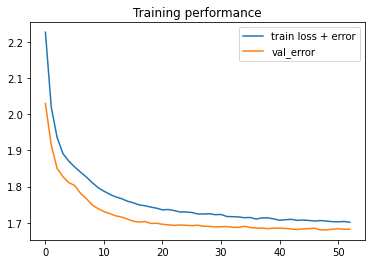

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

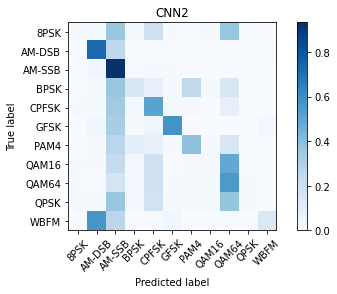

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08580980683506687


Overall Accuracy:  0.09279112754158965


Overall Accuracy:  0.09508660303994344


Overall Accuracy:  0.10576247364722417


Overall Accuracy:  0.1315028901734104


Overall Accuracy:  0.19477264590046545


Overall Accuracy:  0.2601218201361519


Overall Accuracy:  0.3550145348837209


Overall Accuracy:  0.44373446929357474
Overall Accuracy:  0.47124370956146655


Overall Accuracy:  0.48474945533769065


Overall Accuracy:  0.5012621709340065


Overall Accuracy:  0.4990512333965844


Overall Accuracy:  0.4973880597014925
Overall Accuracy:  0.48378962536023057


Overall Accuracy:  0.4998177178271965
Overall Accuracy:  0.5090707145501666


Overall Accuracy:  0.5077096652877021


Overall Accuracy:  0.5187914517317612


Overall Accuracy:  0.5222222222222223


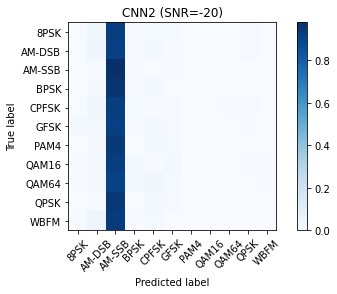

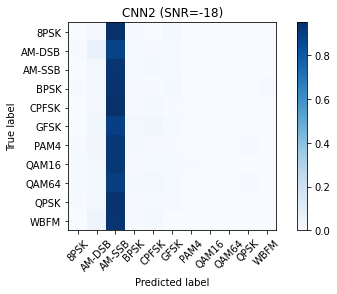

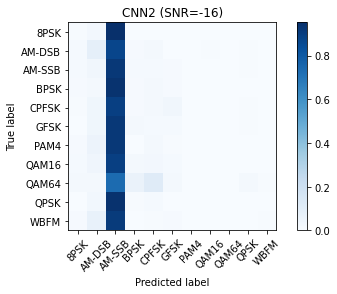

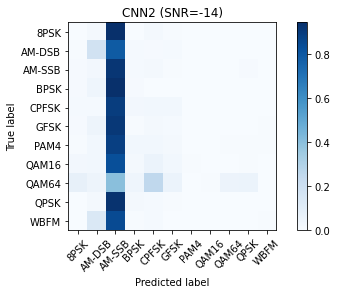

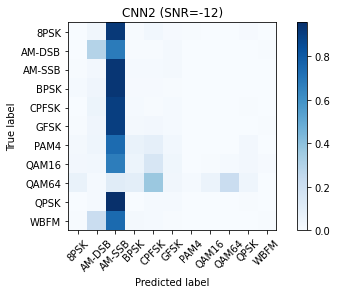

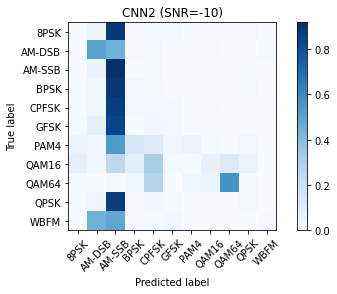

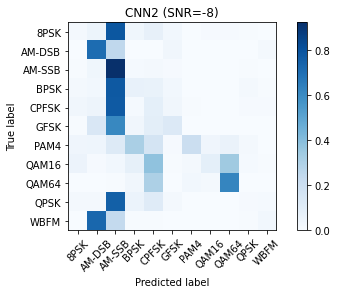

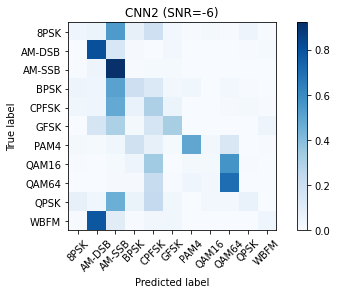

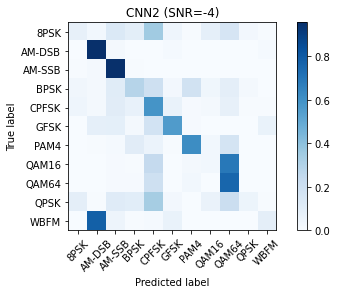

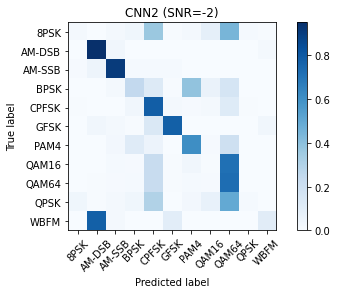

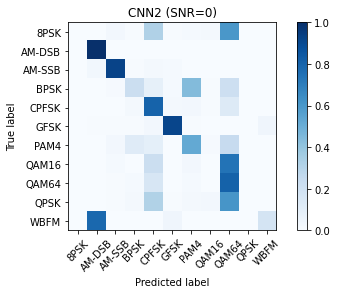

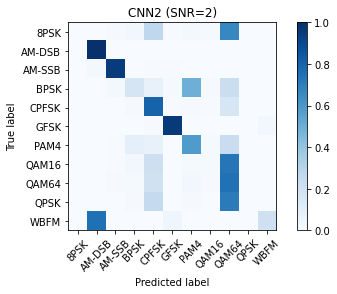

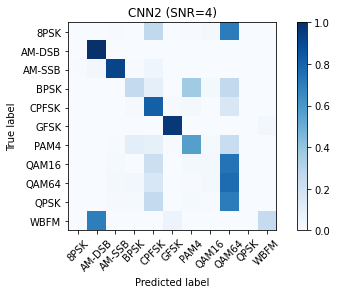

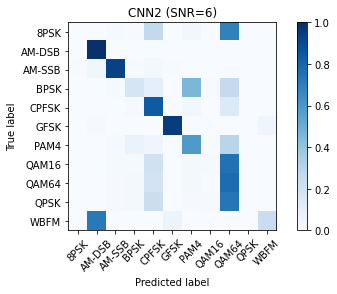

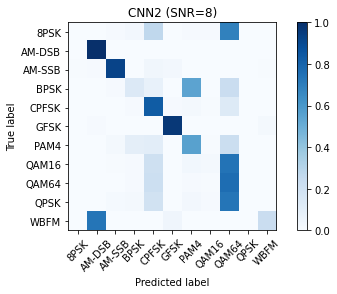

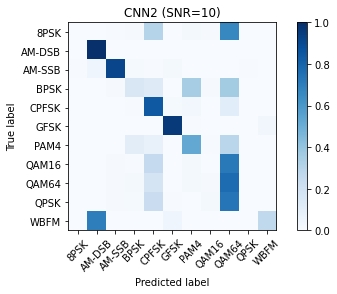

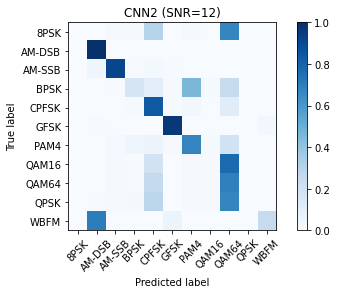

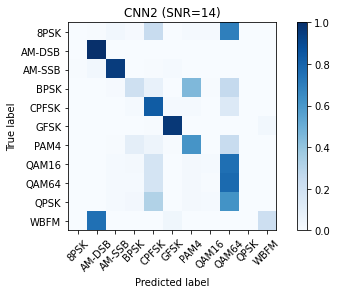

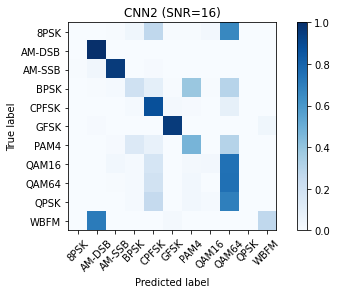

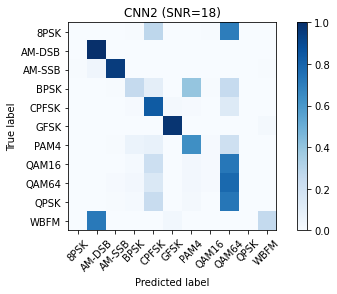

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,13,19,26,35,44,47,48,50,49,49,48,49,50,50,51,52


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

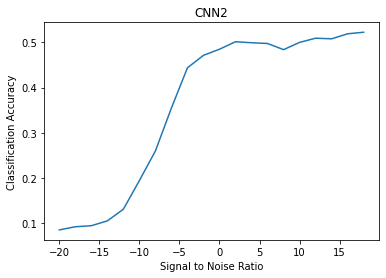

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)